In [1]:
import pandas as pd
df_full = pd.read_csv('final_df.csv')

In [2]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519977 entries, 0 to 519976
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    518920 non-null  object
 1   Result  519977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ MB


In [3]:
df_full.head()

,Text,Result
0,forecast,0
1,traveling business meeting take fun trip espec...,0
2,test test successful way go,0
3,randy send schedule salary level everyone sche...,0
4,hello let shoot tuesday,0


In [4]:
df_full.isnull().sum()

Text      1057
Result       0
dtype: int64

In [5]:
df_full = df_full.dropna()

In [6]:
df_full.shape

(518920, 2)

# Data Splitting

In [7]:
print(df_full['Result'].value_counts())

0    516457
1      2463
Name: Result, dtype: int64


In [8]:
results = df_full['Result'].value_counts()
total = results.sum()

percentage_normal = (results[0] / total) * 100
percentage_spam = (results[1] / total) * 100

print(f'Percentage of Normal: {percentage_normal:.2f}%')
print(f'Percentage of Spam: {percentage_spam:.2f}%')


Percentage of Normal: 99.53%
Percentage of Spam: 0.47%


In [9]:
spam_df = df_full[df_full['Result'] == 1]

num_samples = len(spam_df) * 10
normal_df = df_full[df_full['Result'] == 0].sample(n=num_samples, random_state=1)

df = pd.concat([spam_df, normal_df])

# Shuffle the resulting DataFrame
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27093 entries, 0 to 27092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    27093 non-null  object
 1   Result  27093 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 423.5+ KB
None
                                                Text  Result
0  mimeversion task assignmentstatus completedtas...       0
1  mimeversion contenttype textplain charsetusasc...       0
2  metro downtown route change employee ride metr...       0
3  isda schedule enroneweb transaction fyi propos...       0
4  check election link electoral map page hoskins...       0


##  Resampling Dataset

In [10]:
results = df['Result'].value_counts()
total = results.sum()

percentage_normal = (results[0] / total) * 100
percentage_spam = (results[1] / total) * 100

print(f'Percentage of Normal: {percentage_normal:.2f}%')
print(f'Percentage of Spam: {percentage_spam:.2f}%')
print(df['Result'].value_counts())

Percentage of Normal: 90.91%
Percentage of Spam: 9.09%
0    24630
1     2463
Name: Result, dtype: int64


# Term Frequency - Inverse Document Frequency (TF-IDF)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils import resample

X = df['Text']
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features = 100)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Dummy Classifier

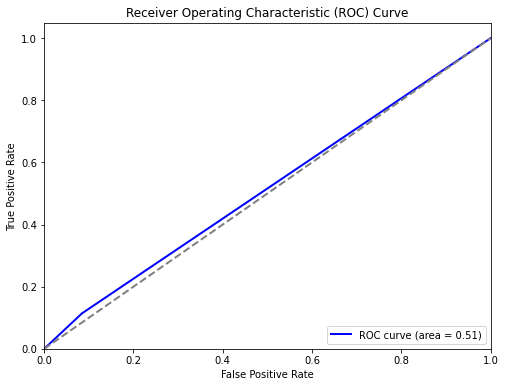

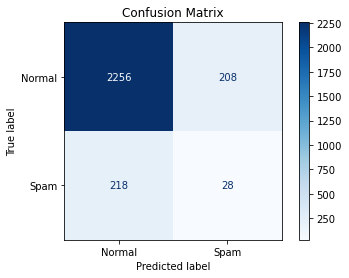

Accuracy: 0.8428
Precision: 0.1186
Recall: 0.1138
AUC: 0.5147


In [22]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = dummy_clf.predict(X_test_tfidf)
y_pred_proba = dummy_clf.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {roc_auc:.4f}')

# Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2464
           1       0.94      0.67      0.78       246

    accuracy                           0.97      2710
   macro avg       0.95      0.83      0.88      2710
weighted avg       0.97      0.97      0.96      2710

Confusion Matrix:


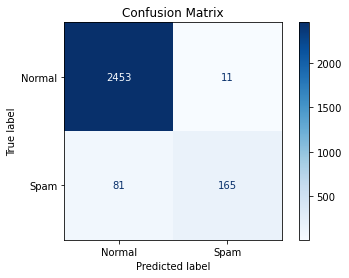

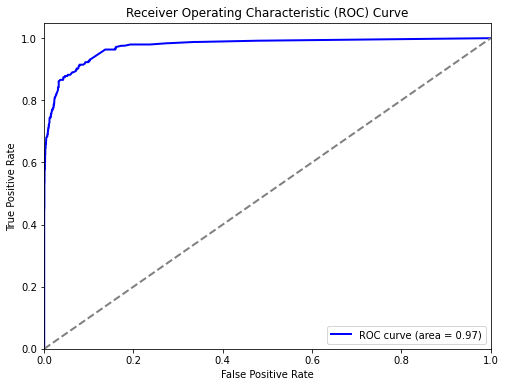

Accuracy: 0.9661
Precision: 0.9375
Recall: 0.6707
AUC: 0.9749


In [23]:
from sklearn.ensemble import RandomForestClassifier

# Train RandomForest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test_tfidf)
y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=['Normal', 'Spam'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print results
print(f'Accuracy: {accuracy_rf:.4f}')
print(f'Precision: {precision_rf:.4f}')
print(f'Recall: {recall_rf:.4f}')
print(f'AUC: {roc_auc_rf:.4f}')


## Grid Search

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
ROC AUC: 0.9724
Accuracy: 0.9606
Precision: 0.9600
Recall: 0.5913
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
ROC AUC: 0.9724
Accuracy: 0.9607
Precision: 0.9614
Recall: 0.5913
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
ROC AUC: 0.9725
Accuracy: 0.9610
Precision: 0.9629
Recall: 0.5936
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
ROC AUC: 0.9722
Accuracy: 0.9605
Precision: 0.9618
Recall: 0.5891
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 

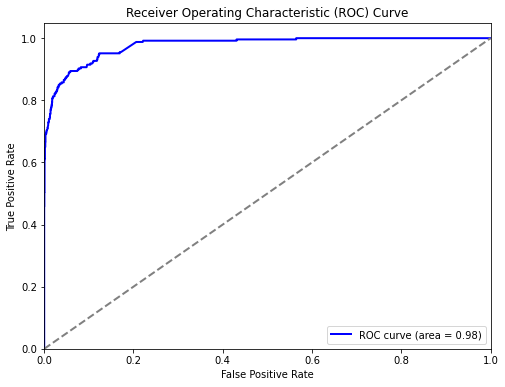

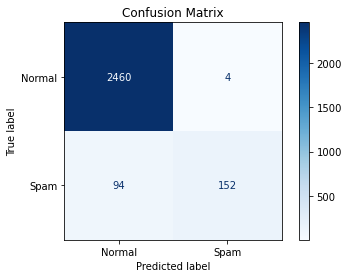

Accuracy: 0.9638
Precision: 0.9744
Recall: 0.6179
ROC AUC: 0.9773


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [20, 30, 50],
    'min_samples_split': [2, 5, 10],
}

# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Define the scoring metric
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scoring, refit='roc_auc', cv=3, verbose=2, n_jobs=-1, return_train_score=True)

# Fit Grid Search to the data
grid_search.fit(X_train_tfidf, y_train)

# Print out the results for each parameter combination
results = grid_search.cv_results_
for i in range(len(results['params'])):
    print(f"Params: {results['params'][i]}")
    print(f"ROC AUC: {results['mean_test_roc_auc'][i]:.4f}")
    print(f"Accuracy: {results['mean_test_accuracy'][i]:.4f}")
    print(f"Precision: {results['mean_test_precision'][i]:.4f}")
    print(f"Recall: {results['mean_test_recall'][i]:.4f}")
    print('-' * 60)
    
# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Display the best estimator
best_clf = grid_search.best_estimator_
print("Best estimator found: ", best_clf)

# Evaluate the best estimator on the test set
y_pred = best_clf.predict(X_test_tfidf)
y_pred_proba = best_clf.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')


## Cross Validation

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Perform cross-validation on the training data with the best estimator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_clf, X_train_tfidf, y_train, cv=cv, scoring='roc_auc')

print(f'Cross-validation ROC AUC scores: {cv_scores}')
print(f'Mean cross-validation ROC AUC: {cv_scores.mean():.4f}')
print(f'Standard deviation of cross-validation ROC AUC: {cv_scores.std():.4f}')

Cross-validation ROC AUC scores: [0.98043591 0.97982347 0.98059649 0.9736908  0.97420867]
Mean cross-validation ROC AUC: 0.9778
Standard deviation of cross-validation ROC AUC: 0.0031


# Embeddings

## Bag-of-Words

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply preprocessing to the training and test data
X_train_preprocessed = X_train.apply(preprocess_text)
X_test_preprocessed = X_test.apply(preprocess_text)

bow_vectorizer = CountVectorizer(max_features=1000)
X_train_bow = bow_vectorizer.fit_transform(X_train_preprocessed)
X_test_bow = bow_vectorizer.transform(X_test_preprocessed)


[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  20.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  21.9s
[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=300; total time=  17.6s
[CV] END max_depth=20, max_features=log2, min_samples_split=10, n_estimators=500; total time=  26.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  17.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=500; total time=  46.0s
[CV] END max_depth=30, max_features=log2, min_samples_split=10, n_estimators=500; total time=  36.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  21.3s
[CV] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=200; total time=  18.2s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=200; total time=  

[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=  36.1s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=500; total time=  29.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  28.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  26.7s
[CV] END max_depth=30, max_features=log2, min_samples_split=2, n_estimators=500; total time=  36.8s
[CV] END max_depth=50, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  37.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_split=10, n_estimators=500; total time=  54.9s
[CV] END max_depth=50, max_features=log2, min_samples_split=10, n_estimators=300; total time=  23.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  21.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500; total time=  38

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
ROC AUC: 0.9840
Accuracy: 0.9680
Precision: 0.9979
Recall: 0.6491
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
ROC AUC: 0.9837
Accuracy: 0.9681
Precision: 0.9979
Recall: 0.6504
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
ROC AUC: 0.9836
Accuracy: 0.9683
Precision: 0.9979
Recall: 0.6531
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
ROC AUC: 0.9837
Accuracy: 0.9667
Precision: 0.9972
Recall: 0.6355
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 

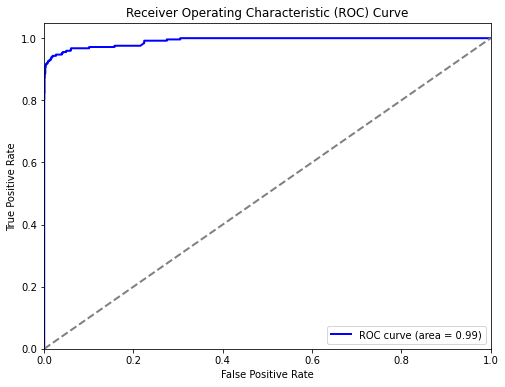

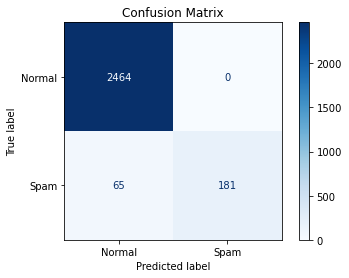

Accuracy: 0.9760
Precision: 1.0000
Recall: 0.7358
ROC AUC: 0.9914


In [31]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [20, 30, 50],
    'min_samples_split': [2, 5, 10],
}

# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Define the scoring metric
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scoring, refit='roc_auc', cv=3, verbose=2, n_jobs=-1, return_train_score=True)

# Fit Grid Search to the data
grid_search.fit(X_train_bow, y_train)

# Print out the results for each parameter combination
results = grid_search.cv_results_
for i in range(len(results['params'])):
    print(f"Params: {results['params'][i]}")
    print(f"ROC AUC: {results['mean_test_roc_auc'][i]:.4f}")
    print(f"Accuracy: {results['mean_test_accuracy'][i]:.4f}")
    print(f"Precision: {results['mean_test_precision'][i]:.4f}")
    print(f"Recall: {results['mean_test_recall'][i]:.4f}")
    print('-' * 60)
    
# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Display the best estimator
best_clf = grid_search.best_estimator_
print("Best estimator found: ", best_clf)

# Evaluate the best estimator on the test set
y_pred = best_clf.predict(X_test_bow)
y_pred_proba = best_clf.predict_proba(X_test_bow)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')


# Word2Vec

In [20]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from gensim.models import Word2Vec

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Apply preprocessing
X_train_tokens = X_train.apply(preprocess_text)
X_test_tokens = X_test.apply(preprocess_text)

# Train Word2Vec model
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to get average Word2Vec vector for a text
def get_w2v_vector(tokens, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for token in tokens:
        if token in model.wv:
            vector += model.wv[token]
            count += 1
    if count > 0:
        vector /= count
    return vector

# Transform text data to Word2Vec vectors
X_train_w2v = np.array([get_w2v_vector(tokens, w2v_model) for tokens in X_train_tokens])
X_test_w2v = np.array([get_w2v_vector(tokens, w2v_model) for tokens in X_test_tokens])



Fitting 3 folds for each of 54 candidates, totalling 162 fits
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
ROC AUC: 0.9915
Accuracy: 0.9798
Precision: 0.9747
Recall: 0.7984
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
ROC AUC: 0.9918
Accuracy: 0.9797
Precision: 0.9741
Recall: 0.7975
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
ROC AUC: 0.9920
Accuracy: 0.9798
Precision: 0.9747
Recall: 0.7988
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
ROC AUC: 0.9913
Accuracy: 0.9794
Precision: 0.9740
Recall: 0.7948
------------------------------------------------------------
Params: {'max_depth': 20, 'max_features': 'sqrt', 

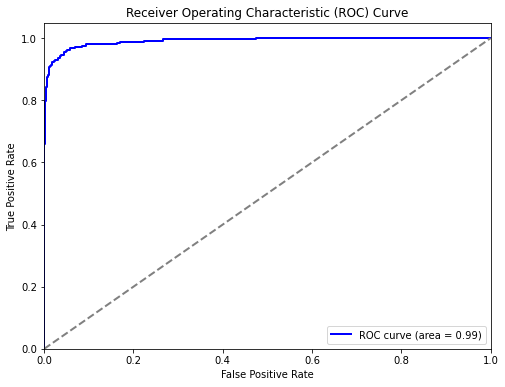

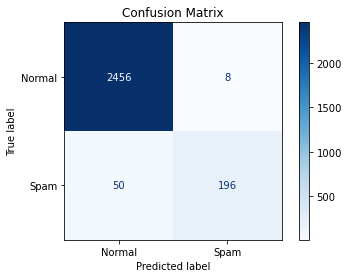

Accuracy: 0.9786
Precision: 0.9608
Recall: 0.7967
ROC AUC: 0.9907
[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500; total time=  30.6s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=500; total time=  15.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  27.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  25.7s
[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=300; total time=  14.9s
[CV] END max_depth=30, max_features=log2, min_samples_split=10, n_estimators=300; total time=  13.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_split=2, n_estimators=500; total time= 1.1min
[CV] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=500; total time=  37.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300; total time= 1.2min
[CV] END max_depth=20, max_featu

[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=  31.3s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=500; total time=  15.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=  27.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  25.5s
[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=200; total time=  10.1s
[CV] END max_depth=30, max_features=log2, min_samples_split=10, n_estimators=200; total time=   9.3s
[CV] END max_depth=30, max_features=log2, min_samples_split=10, n_estimators=500; total time=  22.7s
[CV] END max_depth=50, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  37.4s
[CV] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=200; total time=  14.6s
[CV] END max_depth=50, max_features=log2, min_samples_split=5, n_estimators=200; total time=  14.

[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  18.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  17.2s
[CV] END max_depth=20, max_features=log2, min_samples_split=5, n_estimators=300; total time=   9.2s
[CV] END max_depth=20, max_features=log2, min_samples_split=10, n_estimators=500; total time=  14.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  26.8s
[CV] END max_depth=30, max_features=log2, min_samples_split=2, n_estimators=200; total time=  10.0s
[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=200; total time=  10.1s
[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=500; total time=  24.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  38.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_split=10, n_estimators=500; total time=  58.

[CV] END max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300; total time=  18.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500; total time=  29.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=  18.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500; total time=  46.0s
[CV] END max_depth=30, max_features=log2, min_samples_split=5, n_estimators=500; total time=  24.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_split=5, n_estimators=200; total time=  25.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_split=10, n_estimators=300; total time=  33.9s
[CV] END max_depth=50, max_features=log2, min_samples_split=2, n_estimators=500; total time=  37.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500; total time= 2.1min
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=300; total time=  52.0

In [32]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [20, 30, 50],
    'min_samples_split': [2, 5, 10],
}

# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Define the scoring metric
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scoring, refit='roc_auc', cv=3, verbose=2, n_jobs=-1, return_train_score=True)

# Fit Grid Search to the data
grid_search.fit(X_train_w2v, y_train)

# Print out the results for each parameter combination
results = grid_search.cv_results_
for i in range(len(results['params'])):
    print(f"Params: {results['params'][i]}")
    print(f"ROC AUC: {results['mean_test_roc_auc'][i]:.4f}")
    print(f"Accuracy: {results['mean_test_accuracy'][i]:.4f}")
    print(f"Precision: {results['mean_test_precision'][i]:.4f}")
    print(f"Recall: {results['mean_test_recall'][i]:.4f}")
    print('-' * 60)
    
# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Display the best estimator
best_clf = grid_search.best_estimator_
print("Best estimator found: ", best_clf)

# Evaluate the best estimator on the test set
y_pred = best_clf.predict(X_test_w2v)
y_pred_proba = best_clf.predict_proba(X_test_w2v)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')


# Compared to TD-IDF, BOW, and Word2Vec, BOW is better.

# Handle imbalanced data

## OverSampling

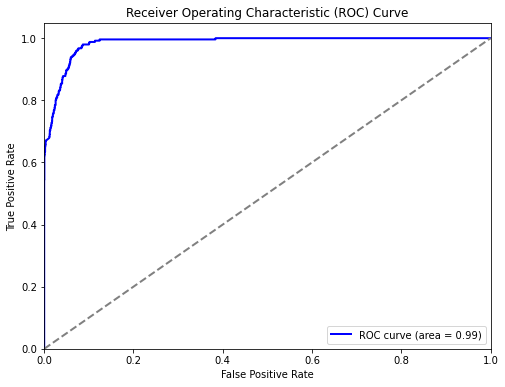

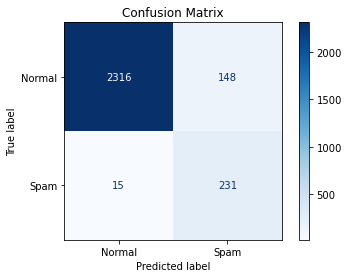

Accuracy: 0.9399
Precision: 0.6095
Recall: 0.9390


In [43]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_bow, y_train)

# Train the Random Forest classifier on the resampled dataset
clf = RandomForestClassifier(max_depth= 50, max_features='log2', min_samples_split=2, n_estimators=300, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = clf.predict(X_test_bow)
y_pred_proba = clf.predict_proba(X_test_bow)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


## Undersampling

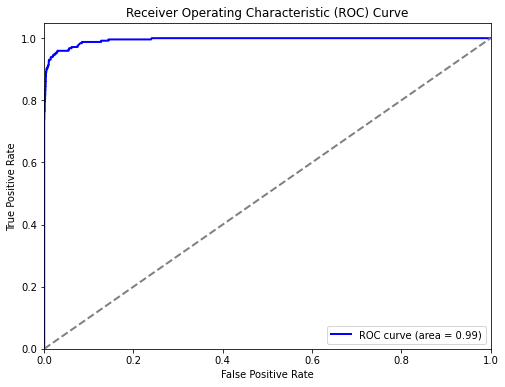

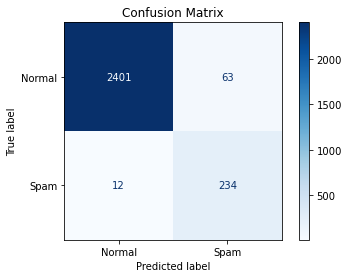

Accuracy: 0.9723
Precision: 0.7879
Recall: 0.9512
ROC AUC: 0.9947


In [44]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler to balance the classes in the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_bow, y_train)

# Train the Random Forest classifier on the resampled dataset
clf = RandomForestClassifier(max_depth= 50, max_features='log2', min_samples_split=2, n_estimators=300, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = clf.predict(X_test_bow)
y_pred_proba = clf.predict_proba(X_test_bow)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')


## "class_weight" parameter for RandomForest classifier
### BOW

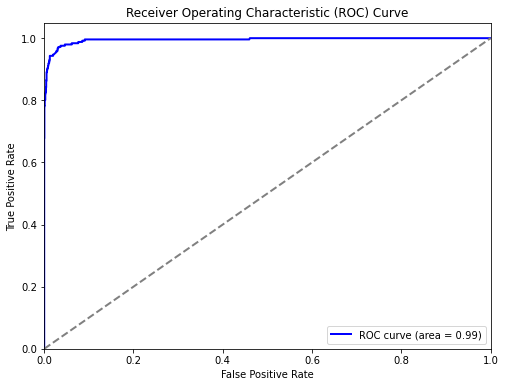

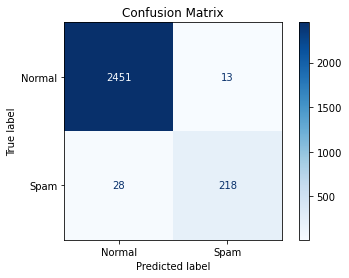

Accuracy: 0.9849
Precision: 0.9437
Recall: 0.8862
ROC AUC: 0.9948


In [37]:
# Train the Random Forest classifier with class weights,
# the classes will be weighted inversely proportional to how frequently they appear in the data.
clf = RandomForestClassifier(max_depth= 50, max_features='log2', min_samples_split=2, n_estimators=300, random_state=42,class_weight='balanced')
clf.fit(X_train_bow, y_train)

# Make predictions
y_pred = clf.predict(X_test_bow)
y_pred_proba = clf.predict_proba(X_test_bow)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

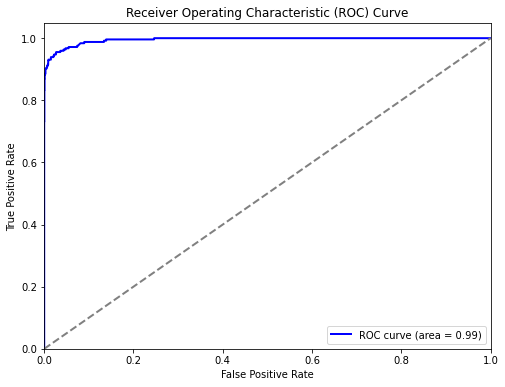

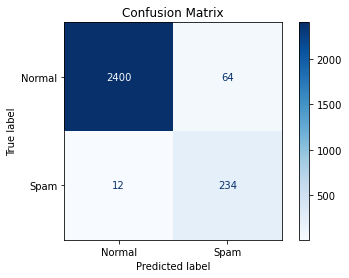

Accuracy: 0.9720
Precision: 0.7852
Recall: 0.9512
ROC AUC: 0.9950


In [47]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Train the Balanced Random Forest classifier
clf = BalancedRandomForestClassifier(max_depth=50, max_features='log2', min_samples_split=2, n_estimators=300, random_state=42)
clf.fit(X_train_bow, y_train)

# Make predictions
y_pred = clf.predict(X_test_bow)
y_pred_proba = clf.predict_proba(X_test_bow)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')


### TF-IDF

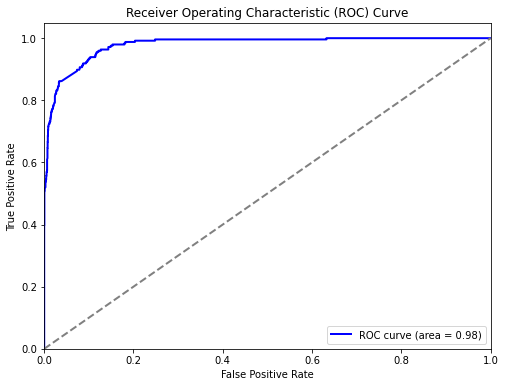

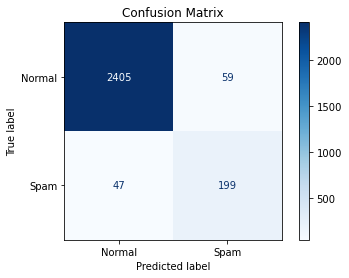

Accuracy: 0.9609
Precision: 0.7713
Recall: 0.8089
ROC AUC: 0.9785


In [40]:
# Train the Random Forest classifier with class weights,
# the classes will be weighted inversely proportional to how frequently they appear in the data.
clf = RandomForestClassifier(max_depth= 30, max_features='log2', min_samples_split=2, n_estimators=500, random_state=42,class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = clf.predict(X_test_tfidf)
y_pred_proba = clf.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

### Word2Vec

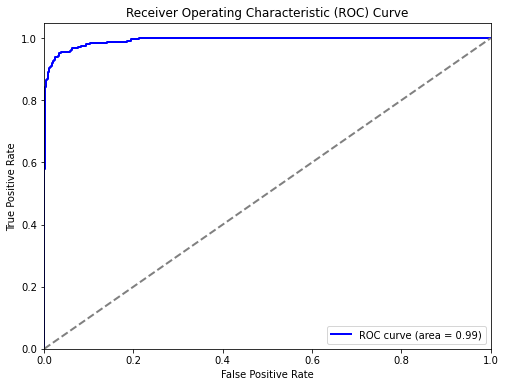

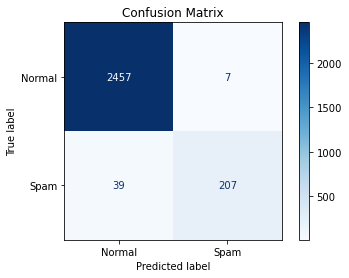

Accuracy: 0.9830
Precision: 0.9673
Recall: 0.8415
ROC AUC: 0.9926


In [41]:
# Train the Random Forest classifier with class weights,
# the classes will be weighted inversely proportional to how frequently they appear in the data.
clf = RandomForestClassifier(max_depth= 20, max_features='log2', min_samples_split=5, n_estimators=200, random_state=42,class_weight='balanced')

clf.fit(X_train_w2v, y_train)

# Make predictions
y_pred = clf.predict(X_test_w2v)
y_pred_proba = clf.predict_proba(X_test_w2v)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')